In [1]:
'''
Run TD3 policy training
Creates new directory ./swimmer3_td3_correct to save tensorboard results
Saves final model as swimmer3_td3_correct


This step should be skipped if trained model is already available

'''

import dmc2gym
import sys
from stable_baselines3.common.callbacks import BaseCallback
import os
import numpy as np
from stable_baselines3.common.results_plotter import load_results

def ts2xy(timesteps, xaxis):
    """
    Decompose a timesteps variable to x ans ys

    :param timesteps: (Pandas DataFrame) the input data
    :param xaxis: (str) the axis for the x and y output
        (can be X_TIMESTEPS='timesteps', X_EPISODES='episodes' or X_WALLTIME='walltime_hrs')
    :return: (np.ndarray, np.ndarray) the x and y output
    """
    if xaxis == X_TIMESTEPS:
        x_var = np.cumsum(timesteps.l.values)
        y_var = timesteps.r.values
    elif xaxis == X_EPISODES:
        x_var = np.arange(len(timesteps))
        y_var = timesteps.r.values
    elif xaxis == X_WALLTIME:
        x_var = timesteps.t.values / 3600.
        y_var = timesteps.r.values
    else:
        raise NotImplementedError
    return x_var, y_var

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq, log_dir, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model at {} timesteps".format(x[-1]))
                    print("Saving new best model to {}.zip".format(self.save_path))
                  self.model.save(self.save_path)

        return True

from tqdm.auto import tqdm

class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
            
        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()

'''

To skip training policy change this to False
'''
if True:
    auto_save_callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir='td3_models')

    env = dmc2gym.make(domain_name='myswimmer', task_name='swimmer', seed=1)
    from stable_baselines3 import PPO, TD3
    model = TD3("MlpPolicy", env, verbose=1, tensorboard_log="./swimmer3_td3_c/") #base sb3
    # with ProgressBarManager(10000) as progress_callback:
    model.learn(total_timesteps=110000, log_interval=10)
    model.save("swimmer3_td3_correct")

/nfs/stak/users/kokatea/hpc-share/anaconda3/envs/py37/lib/python3.7/site-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: Failed to open display localhost:18.0'
  warnings.warn(message, GLFWError)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./swimmer3_td3_c/TD3_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 145      |
| time/              |          |
|    episodes        | 10       |
|    fps             | 127      |
|    time_elapsed    | 78       |
|    total_timesteps | 10000    |
| train/             |          |
|    actor_loss      | -1.85    |
|    critic_loss     | 0.00412  |
|    learning_rate   | 0.001    |
|    n_updates       | 9000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 141      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 121      |
|    time_elapsed    | 164      |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      

In [2]:
'''
Load model from swimmer3_td3_correct
'''

from stable_baselines3 import PPO, TD3
model = TD3.load("swimmer3_td3_correct")

In [4]:
import dmc2gym
import sys
import dm_control.suite
import collections
import numpy as np



# Load Swimmer3 environment from modified dm control suit ssed 10

env_opt = dm_control.suite.load(domain_name='myswimmer', task_name='swimmer', task_kwargs={'random': 10})


def sanitise_action(action):
    #function to force optimal actions into permissible range 
    if action<-1:
        action = -1
    elif action > 1:
        action = 1
    return action

def flatten_obs(obs):
    # flattens observation to list
  obs_pieces = []
  for v in obs.values():
    flat = np.array([v]) if np.isscalar(v) else v.ravel()
    obs_pieces.append(flat)
  return np.concatenate(obs_pieces, axis=0)


# Collect observation, binary actions at head, applied actions and rewards
#for model predicted actions

init_dataset = []
init_targets = []
#env_opt.reset()
init_actions = []
init_rewards = []

# Reset environment to first time step
time_step = env_opt.reset()
obs = flatten_obs(time_step.observation)

while not time_step.last():
    
    #Get observation at current time step
    obs = flatten_obs(time_step.observation)
    
    #get predicted actions
    action, _ = model.predict(obs)
    
    init_dataset.append(obs)
    init_targets.append(1 if action[0]>0 else 0)
    
    # perform action
    time_step = env_opt.step(action)
    # get reward after action is performed
    reward=time_step.reward
    
    init_actions.append(action)
    init_rewards.append(reward)

# Collect observation, binary action at head, optimized actions and rewards
#for model predicted actions    
    
opt_dataset = []
opt_targets = []
opt_actions = []
opt_policy_actions = []
opt_rewards = []

#Use same seed and get Swimmer environment
env_opt = dm_control.suite.load(domain_name='myswimmer', task_name='swimmer', task_kwargs={'random': 10})

# Reset environment to first time step
time_step = env_opt.reset()
obs = flatten_obs(time_step.observation)

while not time_step.last():
    obs = flatten_obs(time_step.observation)
    action, _ = model.predict(obs)
    
    
    action_opt = env_opt._task.get_optimal_action(env_opt._physics)
    opt_dataset.append(obs)
    opt_targets.append(1 if action[0]>0 else 0)
    
    #Apply optimal action change to head node
    action[0] = sanitise_action(action_opt)
    
    time_step = env_opt.step(action)
    reward=time_step.reward
    
    opt_actions.append(action)
    opt_rewards.append(reward)


In [5]:
import csv


'''
Writting intermitten observations to file
'''

with open('activity_optactive_reward-110000', 'w') as csvfile:
    writer=csv.writer(csvfile, delimiter=',')
    writer.writerows(zip(init_dataset,init_actions, init_rewards, init_targets))

In [6]:
with open('activity_optactive_reward2-110000', 'w') as csvfile:
    writer=csv.writer(csvfile, delimiter=',')
    writer.writerows(zip(opt_dataset,opt_actions, opt_rewards, opt_targets))

In [7]:
from sklearn import tree


'''
Creating decision tree for model predictions
'''

clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
clf_init = clf.fit(init_dataset, init_targets)

In [8]:
from sklearn.tree import export_text

'''
39 Observations (9+12+18)
'''
export_text(clf, feature_names=['1','2','3','4','5','6','7','8','9','10',
                               '11','12','13','14','15','16','17','18','19','20',
                               '21','22','23','24','25','26','27','28','29','30',
                               '31','32','33','34','35','36','37','38'])

'|--- 2 <= 2.16\n|   |--- 23 <= 0.83\n|   |   |--- 19 <= 0.02\n|   |   |   |--- class: 0\n|   |   |--- 19 >  0.02\n|   |   |   |--- class: 1\n|   |--- 23 >  0.83\n|   |   |--- 25 <= -0.02\n|   |   |   |--- class: 0\n|   |   |--- 25 >  -0.02\n|   |   |   |--- class: 1\n|--- 2 >  2.16\n|   |--- 19 <= 0.04\n|   |   |--- 9 <= -0.00\n|   |   |   |--- class: 0\n|   |   |--- 9 >  -0.00\n|   |   |   |--- class: 0\n|   |--- 19 >  0.04\n|   |   |--- 18 <= -0.04\n|   |   |   |--- class: 0\n|   |   |--- 18 >  -0.04\n|   |   |   |--- class: 1\n'

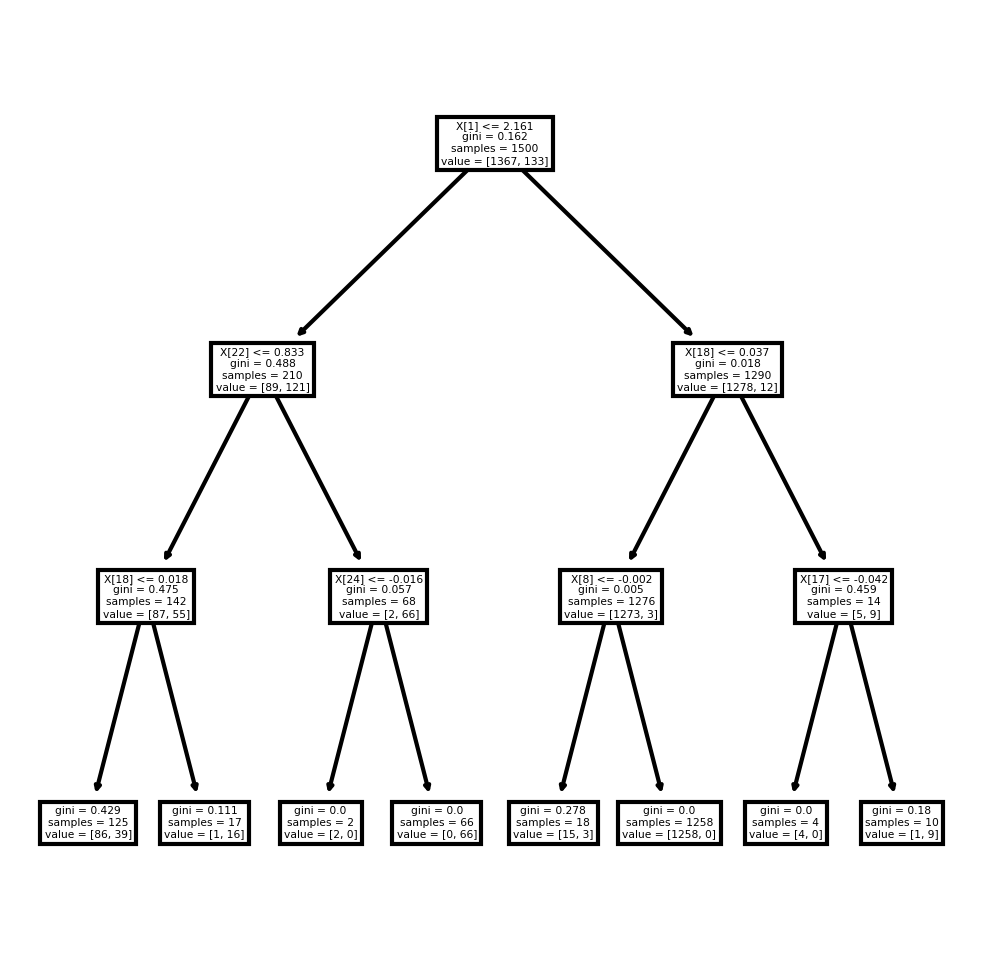

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf)
fig.savefig('initialtree-110000.png')
# plt.savefig('initialtree.png',format='eps',bbox_inches = "tight")

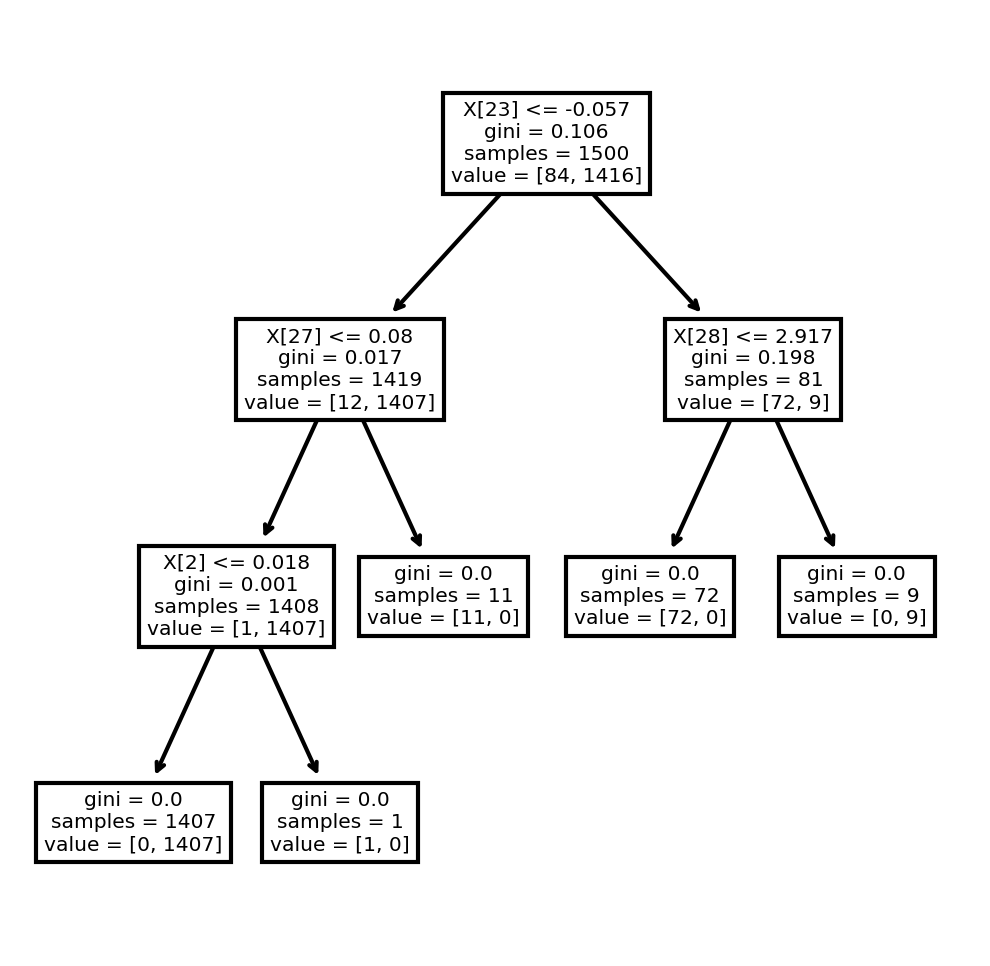

In [10]:
'''
Creating decision tree for optimal predictions
'''
clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3)
clf_opt = clf.fit(opt_dataset, opt_targets)
export_text(clf, feature_names=['1','2','3','4','5','6','7','8','9','10',
                               '11','12','13','14','15','16','17','18','19','20',
                               '21','22','23','24','25','26','27','28','29','30',
                               '31','32','33','34','35','36','37','38'])
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf)
fig.savefig('optimaltree-110000.png')

In [11]:
import bitarray as bt
true_positive = 0
false_positive = 0
opt_classes = clf_opt.predict(opt_dataset)
init_classes = clf_init.predict(opt_dataset)

'''
Calculating policy performance based on trees
'''

accuracy = sum(1 for x,y in zip(opt_classes,init_classes) if x == y) / len(init_classes)
from sklearn.metrics import precision_recall_fscore_support as pr
bPrecis, bRecall, bFscore, bSupport = pr(init_classes, opt_classes, average='binary')

In [12]:
accuracy

0.04

In [13]:
file = open("performance-110000.txt", "w")
file.write("Timesteps = 110000 \nAccuracy = " + str(accuracy) + "\n" +"Precision = "+ str(bPrecis) + "\n"+"Recall = "+ str(bRecall) )
file.close()

In [ ]:
# #
# Define a uniform random policy.
# import matplotlib
# matplotlib.use('TkAgg')
# import matplotlib.pyplot as plt
# # actions =[]
# width = 300
# height = 300
# video = np.zeros((1, height, 2 * width, 3), dtype=np.uint8)
# max_frame =1000
# j=0
# done = False
# print(env.observation_spec().values())
# print(env.action_spec())
# # # plt.show()
# # while not time_step.last():
# #   obs = flatten_obs(time_step.observation)
# #   action, _ = model.predict(obs)
# #   time_step = env.step(action)
# #   reward=time_step.reward
# #   video[0] = np.hstack([env.physics.render(300, 300, camera_id=0),
# #                         env.physics.render(300, 300, camera_id=1)])
# #     # print(time_step.reward, time_step.discount, time_step.observation)
# # # for i in range(max_frame):
# #   img = plt.imshow(video[0])
# #   plt.pause(0.01)  # Need min display time > 0.0.
# #   plt.draw()
# #   j+=1
# #
# # actions=np.array(actions)
# # print(actions.shape)
# # i=0
# ####################